In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
data.shape

(232074, 3)

In [4]:
data['text'] = data['text'].str.lower()
data['text'] = data['text'].replace(r'[^a-z0-9\s]', '', regex=True)
data['text']

0         ex wife threatening suiciderecently i left my ...
1         am i weird i dont get affected by compliments ...
2         finally 2020 is almost over so i can never hea...
3                 i need helpjust help me im crying so hard
4         im so losthello my name is adam 16 and ive bee...
                                ...                        
232069    if you dont like rock then your not going to g...
232070    you how you can tell i have so many friends an...
232071    pee probably tastes like salty tea can someone...
232072    the usual stuff you find hereim not posting th...
232073    i still havent beaten the first boss in hollow...
Name: text, Length: 232074, dtype: object

In [5]:
data.dtypes

Unnamed: 0     int64
text          object
class         object
dtype: object

In [6]:
data['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [7]:
df = data[['text', 'class']]
df.shape

(232074, 2)

In [8]:
df['class_val'] = df['class'].apply(lambda x:1 if x=='suicide' else 0)
df.shape

(232074, 3)

In [9]:
df.head()

,text,class,class_val
0,ex wife threatening suiciderecently i left my ...,suicide,1
1,am i weird i dont get affected by compliments ...,non-suicide,0
2,finally 2020 is almost over so i can never hea...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,im so losthello my name is adam 16 and ive bee...,suicide,1


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

In [11]:
max_features = 5000
max_length = 200

tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(df['text'])
X = pad_sequences(tokenizer.texts_to_sequences(df['text']), maxlen= max_length)
y = df['class_val'].values

In [12]:
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [13]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=16, input_length=max_length, input_shape=(max_length,)))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

/Users/bhagya/Desktop/code/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/bhagya/Desktop/code/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,801 (393.75 KB)

 Trainable params: 100,801 (393.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, epochs=2, batch_size = 64, validation_split=0.2)

Epoch 1/2
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 123s 53ms/step - accuracy: 0.9070 - loss: 0.2460 - val_accuracy: 0.9308 - val_loss: 0.1932
Epoch 2/2
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 121s 52ms/step - accuracy: 0.9306 - loss: 0.1905 - val_accuracy: 0.9306 - val_loss: 0.1921


In [15]:
model.evaluate(X_test, y_test)

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9285 - loss: 0.1953


[0.19529397785663605, 0.9285144805908203]

In [16]:
import re
def predict_class(review_text):
    text = review_text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length)
    prediction = model.predict(padded)[0][0]
    return f"{'suicidal' if prediction >= 0.5 else 'non-suicidal'} (probablity: {prediction:.2f})"
    
text = "hi i am feeling good."
print(f"text: {text}")
print(f"class: {predict_class(text)}")

text: hi i am feeling good.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
class: non-suicidal (probablity: 0.21)


In [18]:
text = "i want to die."
print(f"text: {text}")
print(f"class: {predict_class(text)}")

text: i want to die.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
class: suicidal (probablity: 0.91)


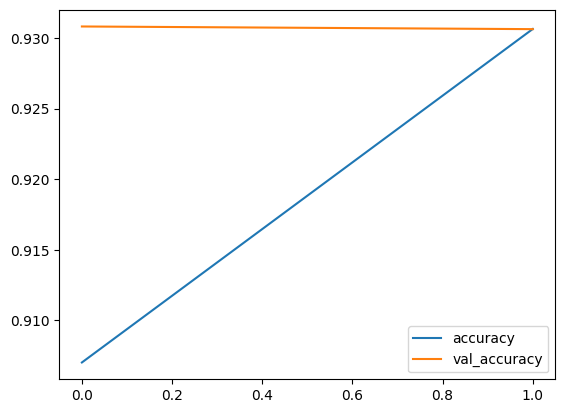

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()